In [559]:
import pandas as pd
import nltk
import pickle
import string
import ssl
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from gensim import corpora
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer

Populating the interactive namespace from numpy and matplotlib


In [74]:
pd.options.display.max_rows = 200

pre-processing

put docs into vectors and then compare (topic modeling, word embedding)

In [5]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


KeyboardInterrupt: 

In [6]:
for dl in ["averaged_perceptron_tagger", "maxent_treebank_pos_tagger", "punkt", "maxent_ne_chunker", "words"]:
    nltk.download(dl)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/danielgilberg/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Sentiment Analysis

In [10]:
conventions = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/convention_speeches.pkl")

In [11]:
example = conventions["Speech"].iloc[35]

In [51]:
def polarity_column(speech):
    return TextBlob(speech).sentiment.polarity

def subjectivity_column(speech):
    return TextBlob(speech).sentiment.subjectivity

conventions["Polarity"] = conventions.apply(lambda row: polarity_column(row["Speech"]),axis=1)
conventions["Subjectivity"] = conventions.apply(lambda row: subjectivity_column(row["Speech"]),axis=1)

In [51]:
conventions.sort_values(by="Polarity", ascending=False)

0     0.169430
1     0.149223
2     0.148300
3     0.170496
4     0.164313
5     0.164060
6     0.109578
7     0.227608
8     0.116004
9     0.147830
10    0.122605
11    0.161397
12    0.132374
13    0.224530
14    0.111130
15    0.162932
16    0.207976
17    0.091104
18    0.142659
19    0.131219
20    0.188553
21    0.090750
22    0.123650
23    0.125737
24    0.096626
25    0.192359
26    0.149597
27    0.197922
28    0.145167
29    0.155669
30    0.150481
31    0.157193
32    0.109210
33    0.115955
34    0.185736
35    0.175929
36    0.193669
37    0.201830
38    0.222832
39    0.162605
40    0.220335
41    0.190437
42    0.159328
43    0.101273
44    0.123333
45    0.112448
46    0.152108
47    0.152144
48    0.129113
49    0.116661
50    0.178712
51    0.152320
52    0.109489
53    0.208297
54    0.136111
Name: Polarity, dtype: float64

In [78]:
nominees = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/nominees.pkl")
nominees
year_sums = nominees.groupby("Year", as_index=False).agg({"Electoral Votes": sum})
year_sums["Majority"] = year_sums.apply(lambda row: row["Electoral Votes"]/2, axis=1)
year_sums = year_sums[["Year", "Majority"]]
nominees = nominees.merge(year_sums, on="Year")
nominees

,Name,Year,Party,Electoral Votes,Result,Majority
0,Hillary Clinton,2016,Democratic,227,Lost,265.5
1,Donald Trump,2016,Republican,304,Won,265.5
2,Barack Obama,2012,Democratic,332,Won,269.0
3,Mitt Romney,2012,Republican,206,Lost,269.0
4,Barack Obama,2008,Democratic,365,Won,269.0
5,John McCain,2008,Republican,173,Lost,269.0
6,John F. Kerry,2004,Democratic,251,Lost,268.5
7,George W. Bush,2004,Republican,286,Won,268.5
8,"Albert Gore, Jr.",2000,Democratic,266,Lost,268.5
9,George W. Bush,2000,Republican,271,Won,268.5


In [14]:
def win_or_lose(votes, majority):
    if votes>=majority:
        return "Won"
    else:
        return "Lost"

In [79]:
nominees["Result"] = nominees.apply(lambda row: win_or_lose(row["Electoral Votes"], row["Majority"]), axis=1)
nominees.drop("Majority", axis=1, inplace=True)

In [81]:
nominees[nominees.Name == "Herbert Hoover"]

,Name,Year,Party,Electoral Votes,Result
46,Herbert Hoover,1932,Republican,59,Lost
48,Herbert Hoover,1928,Republican,444,Won


In [19]:
with open("/Users/danielgilberg/data_science/metis/presidential_speeches/data/nominees.pkl", "wb") as picklefile:
    pickle.dump(nominees, picklefile)

In [52]:
platforms = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/platforms.pkl")
platforms["Polarity"] = platforms.apply(lambda row: polarity_column(row["Platform"]), axis=1)
platforms["Subjectivity"] = platforms.apply(lambda row: subjectivity_column(row["Platform"]), axis=1)

In [100]:
party_years = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/party_years.pkl")

In [128]:
temp_speech = party_years.iloc[0]["Speech"]
sentences = nltk.tokenize.sent_tokenize(temp_speech)
tokenizer = TreebankWordTokenizer()
tokenizer.tokenize(sentences[10])

['What', 'a', 'remarkable', 'week', 'it', "'s", 'been', '!']

In [127]:
nltk.word_tokenize(sentences[10])


['What', 'a', 'remarkable', 'week', 'it', "'s", 'been', '!']

In [118]:
nltk.wordpunct_tokenize(sentences[10])


['What', 'a', 'remarkable', 'week', 'it', "'", 's', 'been', '!']

In [124]:
nltk.tag.pos_tag(nltk.word_tokenize(sentences[10]))

[('What', 'WP'),
 ('a', 'DT'),
 ('remarkable', 'JJ'),
 ('week', 'NN'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('been', 'VBN'),
 ('!', '.')]

In [160]:
arr = textwrap.wrap(temp_speech, len(temp_speech)//20)
temp = list()
for index, x in enumerate(arr):
    if index != len(arr)-1:
        temp.append(TextBlob(x).sentiment.polarity)
        
np.min(temp), np.max(temp)

(-0.036805555555555564, 0.38092105263157888)

Graph sentimentality of a speech as it progresses

In [256]:
len(conventions[conventions.Year>1915])
temp_speech = conventions.iloc[0]["Speech"]
word_vect = nltk.word_tokenize(temp_speech)
sent_vect = nltk.sent_tokenize(temp_speech)
vect = CountVectorizer(ngram_range=(1,2))

temp_platform = platforms.iloc[0]["Platform"]
sent_plat = nltk.sent_tokenize(temp_platform)
vect.fit(sent_plat)
data = vect.transform(sent_vect)
x = pd.DataFrame(data.toarray(), columns=vect.get_feature_names())
x.columns

Index(['000', '000 americans', '10', '10 20', '10 percent', '10 times',
       '10 year', '100', '100 days', '100 percent',
       ...
       'zealand the', 'zero', 'zero suicide', 'zika', 'zika just',
       'zika pandemic', 'zip', 'zip code', 'zones', 'zones and'],
      dtype='object', length=19473)

In [223]:
df = pd.DataFrame(pairwise_distances(data, metric='cosine'))


In [226]:
for col in df.columns:
    print(df[col].mean())

0.874077331325
0.894349709974
0.862866935554
0.866145426545
0.864533821436
0.915794958452
0.887292230208
0.893783303314
0.823832438031
0.862703605232
0.965949491445
0.870756436032
0.946452157671
0.90470905842
0.870351762996
0.916151947004
0.911086697087
0.844371431026
0.817414252574
0.903108059797
0.890291311925
0.892716627472
0.900894670332
0.810379444044
0.963601930181
0.920247888358
0.887842992674
0.901111082175
0.862555083806
0.863535091366
0.853180068356
0.865426977576
0.886260056582
0.893760147618
0.971014032044
0.890349827974
0.949402017349
0.941061932206
0.910055356008
0.906942235048
0.908703336636
0.893705826421
0.911713248695
0.893369331105
0.951442776788
0.840569646329
0.885669077383
0.896094340926
0.871249772678
0.875486396173
0.922465564175
0.928728019437
0.859708993218
0.930170271298
0.849547410649
0.937678965601
0.844097405482
0.901443329234
0.939395046826
0.977632195523
0.930614930615
0.885277367255
0.835160649918
0.862138701442
0.844314111661
0.892644424077
0.970293777

In [300]:
mask = (conventions.Party == "Republican") & (conventions.Year == 2016)
trump_speech = conventions[mask]["Speech"][24]


In [467]:
debate = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/ford_carter_one.pkl")
def get_party(speaker):
    if speaker.lower() == "president":
        return "Republican"
    elif speaker.lower() == "carter":
        return "Democratic"
    else:
        return "N/A"
    
def get_polarity(transcript):
    return TextBlob(transcript).sentiment.polarity

debate["Party"] = debate.apply(lambda row: get_party(row["Speaker"]),axis=1)
debate["Polarity"] = debate.apply(lambda row:get_polarity(row["Transcript"]), axis=1)

In [540]:
potus_speeches = pd.read_pickle("/Users/danielgilberg/data_science/metis/presidential_speeches/data/speeches.pkl")

In [541]:
potus_speeches

,President,Date,Speech
0,Donald Trump,"February 28, 2017","Mr. Speaker, Mr. Vice President, Members of C..."
1,Donald Trump,"January 20, 2017","Chief Justice Roberts, President Carter, Pres..."
2,Barack Obama,"May 15, 2016",Hello Rutgers! (Applause.) R-U rah-rah! (A...
3,Barack Obama,"March 22, 2016",Thank you. (Applause.) Muchas gracias. Tha...
4,Barack Obama,"January 12, 2016","Mr. Speaker, Mr. Vice President, Members of C..."
5,Barack Obama,"June 26, 2015",THE PRESIDENT: Giving all praise and honor t...
6,Barack Obama,"March 07, 2015","UDIENCE MEMBER: We love you, President Obama..."
7,Barack Obama,"January 20, 2015","Mr. Speaker, Mr. Vice President, Members of C..."
8,Barack Obama,"November 20, 2014","My fellow Americans, tonight, I'd like to tal..."
9,Barack Obama,"January 28, 2014","Mr. Speaker, Mr. Vice President, Members of C..."


97

### Modeling

In [539]:
temp_platform = platforms.iloc[0]["Platform"]
temp_speech = conventions.iloc[0]["Speech"]
sentences = nltk.tokenize.sent_tokenize(temp_platform)

my_stops = stopwords.words('english') + ["Trump", "Donald", "Americans", "Democrats", 
                                         "Obama", "President", "democrats", "donald", "trump"]

#sentences = np.reshape(sentences, (-1,1))
cv = CountVectorizer(stop_words=my_stops)
cv_fit = cv.fit_transform(sentences)
lda = LatentDirichletAllocation()
lda.fit(cv_fit)
comps = lda.components_
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([cv.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic #0:
energy obama president also clean country workers communities republican law
Topic #1:
americans believe crisis jobs many system need paying would must
Topic #2:
support students federal public schools work new programs education build
Topic #3:
wall must street values influence interests special cannot protect american
Topic #4:
al isis terror boko reign haram aqim shabaab promulgated conflict
Topic #5:
income provide low stability wealth economic assistance growth africa people
Topic #6:
nation committed america also dangerous family medical region without women
Topic #7:
nuclear weapons allies iran ban cuba treatment abandon aggression korea
Topic #8:
health people american believe rights support care world country global
Topic #9:
reject end sexual fight gun gender make race partner would


In [538]:
temp_platform = platforms.iloc[1]["Platform"]
temp_speech = conventions.iloc[1]["Speech"]
sentences = nltk.tokenize.sent_tokenize(temp_platform)

my_stops = stopwords.words('english') + ["Trump", "Donald", "Americans", "Democrats", 
                                         "Obama", "President", "democrats", "donald", "trump"]

#sentences = np.reshape(sentences, (-1,1))
cv = CountVectorizer(stop_words=my_stops)
cv_fit = cv.fit_transform(sentences)
lda = LatentDirichletAllocation()
lda.fit(cv_fit)
comps = lda.components_

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([cv.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic #0:
federal government american education must control families energy state would
Topic #1:
special reduce financial protection must tax welfare border debt propose
Topic #2:
human rights world people years one must forces trafficking around
Topic #3:
israel year increased values much understand nation taxpayer puerto ranchers
Topic #4:
need access internet code market technology decision governments ensure regime
Topic #5:
law freedom people government religious country political american women rights
Topic #6:
many republican middle east president countries russia country stand inherent
Topic #7:
states new united president sector millions laws private health government
Topic #8:
administration security national current republican support congress act china legislation
Topic #9:
mike john america american mary david jim steve james virginia


In [572]:
temp_speech = potus_speeches.iloc[25]["Speech"]
remove = temp_speech.maketrans('', '', string.punctuation)
temp_speech = temp_speech.translate(remove)
word_toke = nltk.word_tokenize(temp_speech)
en_stop = get_stop_words('en')
word_toke = [word.lower() for word in word_toke]
p_stemmer = PorterStemmer()
stemmed_toke = [p_stemmer.stem(i) for i in word_toke]
c_vect = CountVectorizer(stop_words=en_stop)
c_fit = c_vect.fit_transform(word_toke)
lda.fit(c_fit)
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([cv.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topic #0:
applied crises burden breaks centers development commonwealth beacon decline abuse
Topic #1:
brown aboriginal claims deploying cyberspace defense affiliates conflicting defined decisions
Topic #2:
affording decided abortion based asian become debtas behavior childbirth defaulting
Topic #3:
dictator attention assist 2013 across billion civic aumf destabilize budged
Topic #4:
affected bureau culturedemocrats 50 collective china debt anyone corruption contribute
Topic #5:
dedicated another adequate abortions collect begun change concerns black afghan
Topic #6:
access cooperate altering citizenship behindwe adjustments choice century belongs allegations
Topic #7:
combat commander contracting abiding child applaud areasdemocrats colleges behavioral continued
Topic #8:
census department chronic directing acquires bay ability adversaries determining according
Topic #9:
dioxide diplomacy clear bondage capability accurate broadly check broken asset


### Visuals

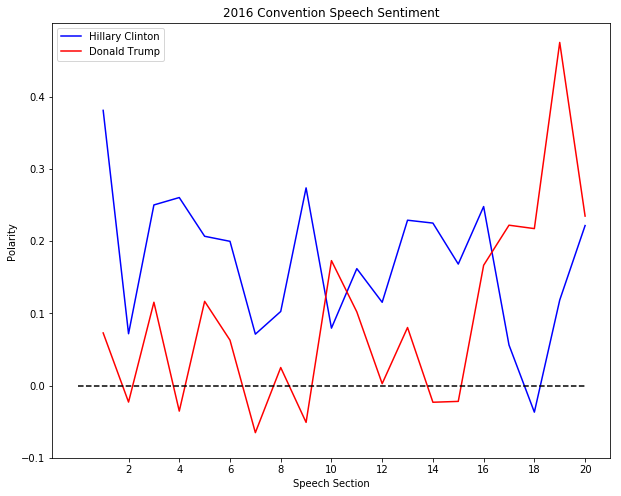

In [319]:
x = range(1,21)
speech_parts = textwrap.wrap(temp_speech, len(temp_speech)//20)[:-1]
dem_y = list()
for a in speech_parts:
    dem_y.append(TextBlob(a).sentiment.polarity)
    

gop_y = list()
trump_parts = textwrap.wrap(trump_speech, len(trump_speech)//20)[:-1]
for a in trump_parts:
    gop_y.append(TextBlob(a).sentiment.polarity)
zeros = np.zeros(21)
plt.figure(figsize=(10,8))
plt.plot(x, dem_y, color="blue", label="Hillary Clinton")
plt.plot(x, gop_y, color="red", label="Donald Trump")
plt.plot(list(range(0,21)), zeros,"--", color="black")
plt.xticks(range(2,21,2))
plt.yticks(np.arange(-0.1, 0.5, 0.1))
plt.xlabel("Speech Section")
plt.ylabel("Polarity")
plt.title("2016 Convention Speech Sentiment")
plt.legend()

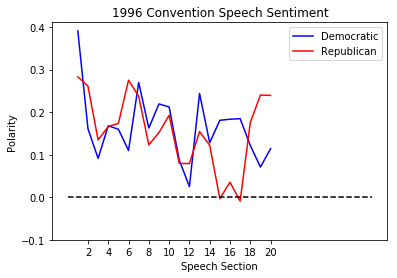

In [429]:
years = list(range(1992, 2017,4))
for year in years[1:2]:
    party_colors = {"Republican": "red", "Democratic": "blue"}
    df = conventions[conventions.Year==year]
    speech1 = df.iloc[0]["Speech"]
    party1 = df.iloc[0]["Party"]
    y1 = list()
    speech1_parts = textwrap.wrap(speech1, len(speech1)//20)[:-1]
    for a in speech1_parts:
        y1.append(TextBlob(a).sentiment.polarity)
    zeros = np.zeros(31)
    speech2 = df.iloc[1]["Speech"]
    party2 = df.iloc[1]["Party"]
    y2 = list()
    speech2_parts = textwrap.wrap(speech2, len(speech2)//20)[:-1]
    for a in speech2_parts:
        y2.append(TextBlob(a).sentiment.polarity)
    x = range(1,21)
    plt.plot(x, y1, color=party_colors[party1], label=party1)
    plt.plot(x, y2, color=party_colors[party2], label=party2)
    plt.plot(list(range(0,31)), zeros,"--", color="black")
    plt.xticks(range(2,21,2))
    plt.yticks(np.arange(-0.1, 0.5, 0.1))
    plt.xlabel("Speech Section")
    plt.ylabel("Polarity")
    plt.title(str(year) + " Convention Speech Sentiment")
    plt.legend()

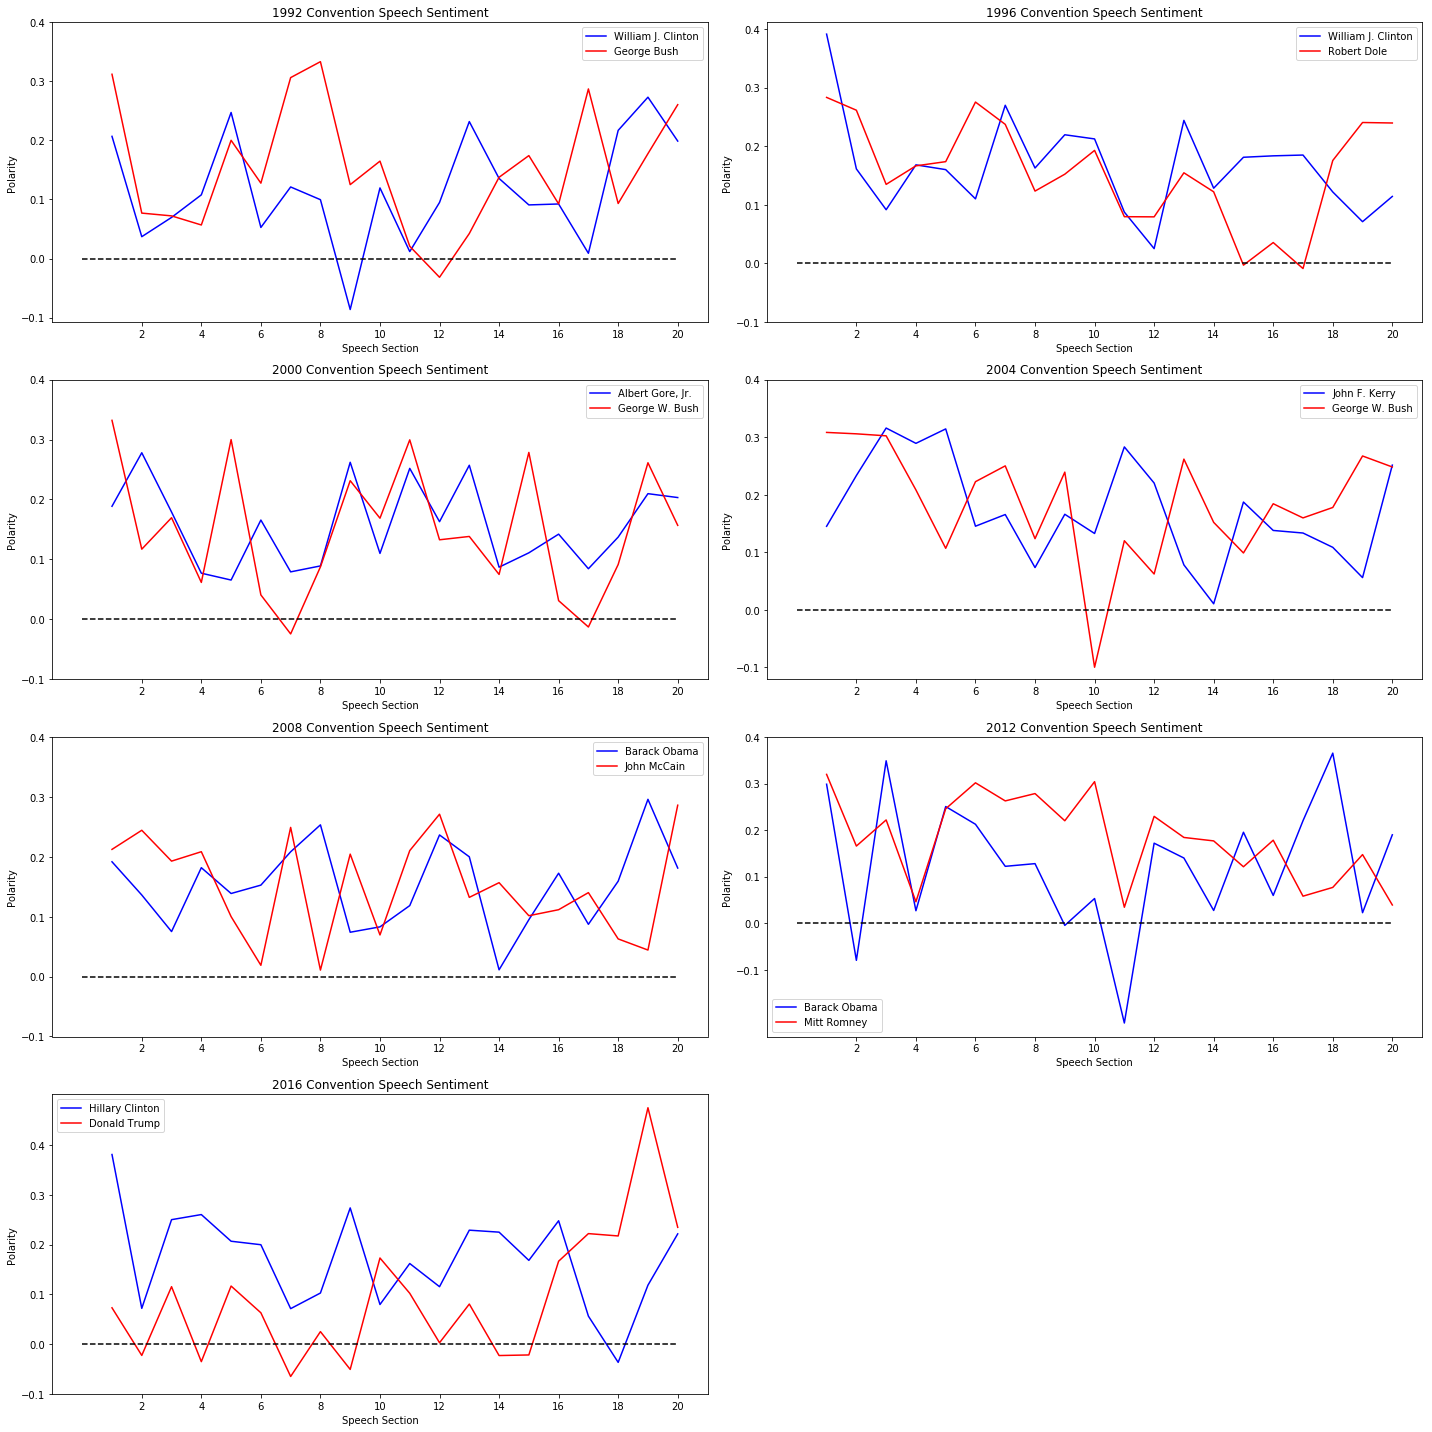

In [433]:
#plt.figure(figsize=(100,300))
fig, axes = plt.subplots(4,2, figsize=(20,20))
fig.tight_layout()
years = list(range(1992,2017,4))
ax_dict = dict(zip(years, axes.flatten()))
#print(ax_dict)
for year in years:
    party_colors = {"Republican": "red", "Democratic": "blue"}
    df = conventions[conventions.Year==year]
    speech1 = df.iloc[0]["Speech"]
    party1 = df.iloc[0]["Party"]
    nominee_df = nominees[(nominees.Party == party1) & (nominees.Year == year)]
    nominee1 = nominee_df.iloc[0]["Name"]
    y1 = list()
    speech1_parts = textwrap.wrap(speech1, len(speech1)//20)[:-1]
    for a in speech1_parts:
        y1.append(TextBlob(a).sentiment.polarity)
        
    speech2 = df.iloc[1]["Speech"]
    party2 = df.iloc[1]["Party"]
    y2 = list()
    speech2_parts = textwrap.wrap(speech2, len(speech2)//20)[:-1]
    for a in speech2_parts:
        y2.append(TextBlob(a).sentiment.polarity)
    
    nominee_df = nominees[(nominees.Party == party2) & (nominees.Year == year)]
    nominee2 = nominee_df.iloc[0]["Name"]
    x = range(1,21)
    
    ax = ax_dict[year]
    zeros = np.zeros(21)
    ax.plot(x, y1, color=party_colors[party1], label=nominee1)
    ax.plot(x, y2, color=party_colors[party2], label=nominee2)
    ax.plot(list(range(0,21)), zeros,"--", color="black")
    ax.set_xticks(range(2,21,2))
    ax.set_yticks(np.arange(-0.1, 0.5, 0.1))
    ax.set_xlabel("Speech Section")
    ax.set_ylabel("Polarity")
    ax.set_title(str(year) + " Convention Speech Sentiment")
    #plt.subplots_adjust(bottom=.1, top=.9)
    ax.legend()
#fig.subplots_adjust(hspace=.7)
fig.delaxes(axes.flatten()[-1])
fig.tight_layout()

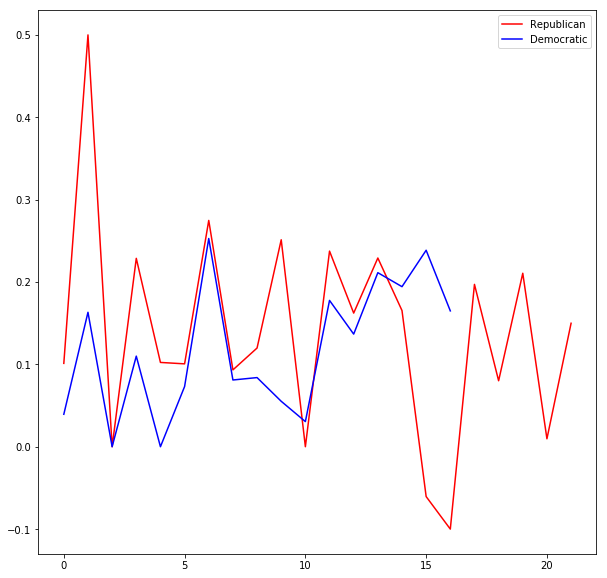

In [466]:
candidates = debate[debate.Party != "N/A"]
x = candidates.groupby("Party", as_index=False).agg(lambda x: " ".join(set(x)))
x["Polarity"] = x.apply(lambda row: TextBlob(row["Transcript"]).sentiment.polarity, axis=1)
y = candidates.Speaker.unique()
plt.figure(figsize=(10,10))
for speaker in y:
    party_colors = {"Republican": "red", "Democratic": "blue"}
    df = candidates[candidates.Speaker == speaker]
    party = df.iloc[0]["Party"]
    end_point = len(df)
    xplot = range(0, end_point)
    yplot = list(df.Polarity)
    plt.plot(xplot, yplot, color=party_colors[party], label=party)

plt.legend()